In [1]:
%matplotlib inline
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy
import seaborn as sns
from skimage import measure # to get contours from masks
import sklearn

import napari

sns.set_theme()

C:\ProgramData\Anaconda3\lib\site-packages\napari\_qt\__init__.py:37: UserWarning: 
    napari was tested with QT library `>=5.12.3`.
    The version installed is 5.9.7. Please report any issues with this
    specific QT version at https://github.com/Napari/napari/issues.
    
  warn(message=warn_message)


In [3]:
os.chdir("D:/Hugo/Anaphase/Analyse_Descriptive")
data = pd.read_csv("Analysis_BF_f0001-1-100.1.csv", sep=";", comment="#")
data = data[data["time_to_anaphase"] >= 0]

print(data.shape)
data.head()

(495, 14)


,idx,frame,time,mom_x,mom_y,daugh_x,daugh_y,mom_surf,daugh_surf,relat_surf,anaphase,anaphase_int,time_to_anaphase,cum_relat_surf
0,0,0,0,463.509804,225.369863,-1.000000,-1.000000,229.730504,0.000000,0.000000,False,0,36,0.000000
1,0,1,6,463.481911,225.084507,460.542099,238.588235,227.730488,9.534260,0.041866,False,0,30,0.020842
2,0,2,12,460.345420,225.602740,456.110886,239.965517,229.730504,36.406857,0.158476,False,0,24,0.066853
3,0,3,18,460.578297,225.698630,455.691877,240.914286,224.730504,51.553944,0.229403,False,0,18,0.106912
4,0,4,24,461.524165,225.985915,456.054041,241.146341,228.446179,68.701031,0.300732,False,0,12,0.145739


In [25]:
from sklearn.model_selection import train_test_split

X = data[["relat_surf", "time"]].values

X_train, X_test, y_train, y_test = train_test_split(X, data["time_to_anaphase"].values, train_size=0.75)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(371, 2) (124, 2) (371,) (124,)


In [26]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression().fit(X_train, y_train)

print(f"R^2 coefficient : {round(lm.score(X_train, y_train), 2)}")

R^2 coefficient : 0.79


Text(0.5, 1.0, 'Linear regression predictions on the training set')

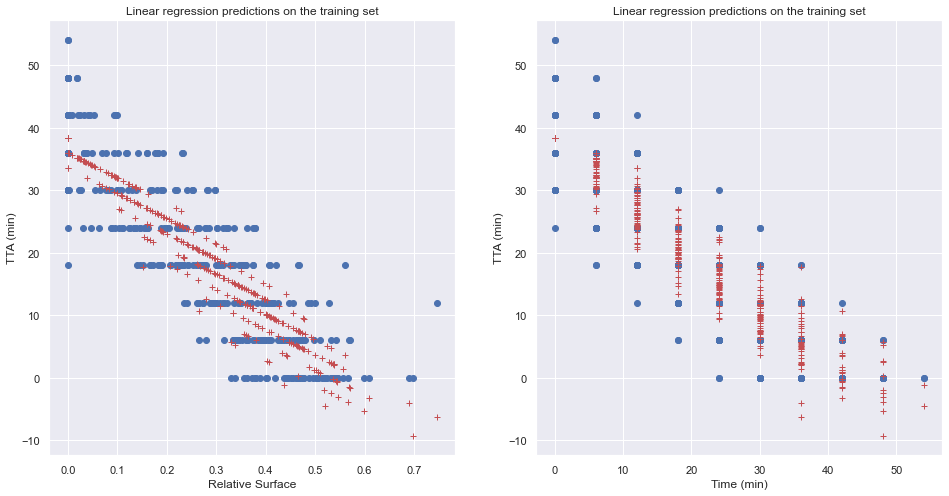

In [33]:
predictions_on_train_set = lm.predict(X_train)

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].scatter(X_train[:, 0], y_train, c='b', label="Train set")
ax[0].plot(X_train[:, 0], predictions_on_train_set, "+", c="r", label="Predictions")
ax[0].set_xlabel("Relative Surface")
ax[0].set_ylabel("TTA (min)")
ax[0].set_title("Linear regression predictions on the training set")

ax[1].scatter(X_train[:, 1], y_train, c='b', label="Train set")
ax[1].plot(X_train[:, 1], predictions_on_train_set, "+", c="r", label="Predictions")
ax[1].set_xlabel("Time (min)")
ax[1].set_ylabel("TTA (min)")
ax[1].set_title("Linear regression predictions on the training set")

### Evaluation

Text(0.5, 1.0, 'Linear regression predictions on the evaluation set')

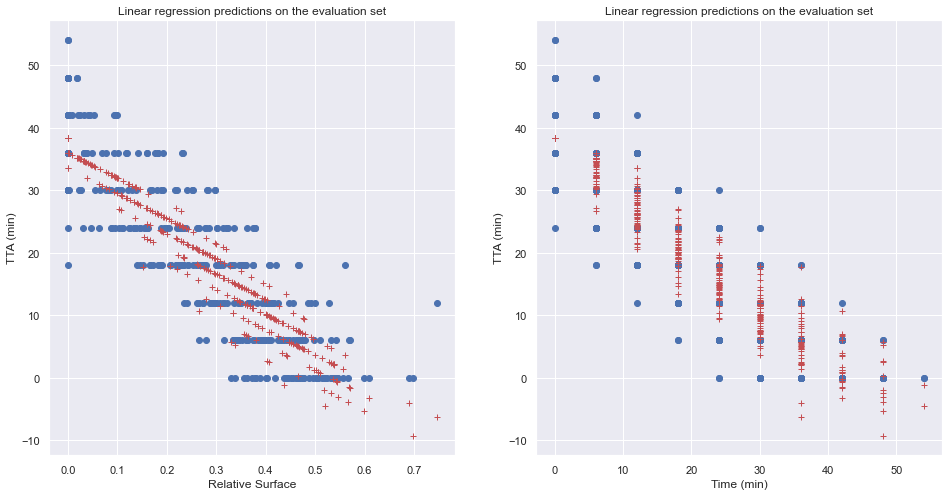

In [35]:
predictions_on_test_set = lm.predict(X_train)

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].scatter(X_train[:, 0], y_train, c='b', label="Train set")
ax[0].plot(X_train[:, 0], predictions_on_test_set, "+", c="r", label="Predictions")
ax[0].set_xlabel("Relative Surface")
ax[0].set_ylabel("TTA (min)")
ax[0].set_title("Linear regression predictions on the evaluation set")

ax[1].scatter(X_train[:, 1], y_train, c='b', label="Train set")
ax[1].plot(X_train[:, 1], predictions_on_test_set, "+", c="r", label="Predictions")
ax[1].set_xlabel("Time (min)")
ax[1].set_ylabel("TTA (min)")
ax[1].set_title("Linear regression predictions on the evaluation set")

Mean squared error : 14.891514390677171


ValueError: x and y must be the same size

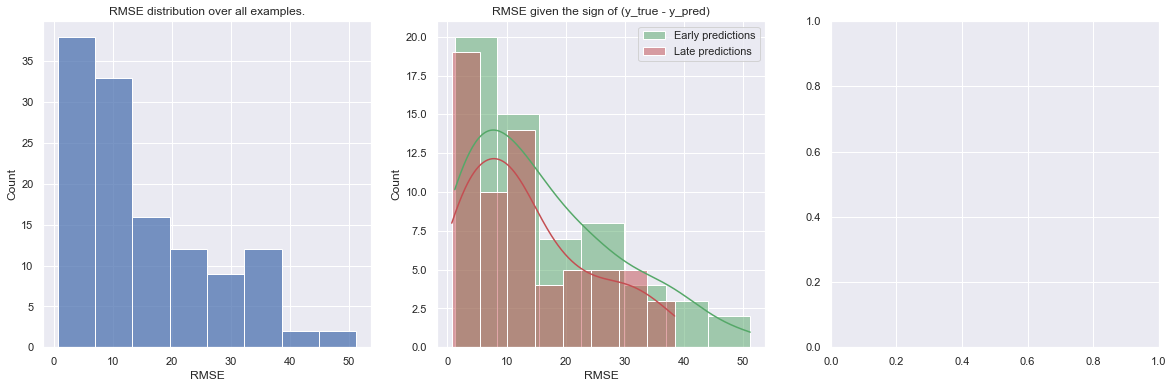

In [36]:
# evaluation with the clasical RMSE
losses, signed_losses = [], []
for obs, pred, gt in zip(X_test, predictions_on_test_set, y_test):
    loss = np.sqrt((pred - gt) ** 2)
    signed_losses.append(gt - pred)
    losses.append(loss)
losses = np.array(losses) 
signed_losses = np.array(signed_losses)

print(f"Mean squared error : {losses.mean()}")

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# RMSE distribution
sns.histplot(losses, ax=axes[0])
axes[0].set_title("RMSE distribution over all examples.")
axes[0].set_xlabel("RMSE")

# Conditional distributions given the sign of the error
sns.histplot(losses[signed_losses >= 0], color="g", kde=True, label="Early predictions", ax=axes[1])
sns.histplot(losses[signed_losses < 0], color="r", kde=True, label="Late predictions", ax=axes[1])
axes[1].legend()
axes[1].set_xlabel("RMSE")
axes[1].set_title("RMSE given the sign of (y_true - y_pred)")

# conditional distributions of the points
axes[2].scatter(X_test[signed_losses >= 0], y_test[signed_losses >= 0], c="g", label="Early predictions")
axes[2].scatter(X_test[signed_losses < 0], y_test[signed_losses < 0], c="r", label="Late predictions")
axes[2].plot(X_test, predictions_on_test_set, c="black", label="Linear regression curve")
axes[2].legend()
axes[2].set_xlabel("Relative cumulative surface")
axes[2].set_ylabel("TTA (min)")
axes[2].set_title("Observations given the sign of (y_true - y_pred)")

## Save predictions

In [28]:
predictions = []
for i, row in data.iterrows():
    if row["time_to_anaphase"] >= 0:
        p = lm.predict(np.array(row["relat_surf"]).reshape(-1, 1))
        predictions.append(p[0])
    else:
        predictions.append(-1)
        
data["predictions_tta"] = predictions
data = data.drop("predictions", axis=1)

data.head()

,idx,frame,time,mom_x,mom_y,daugh_x,daugh_y,mom_surf,daugh_surf,relat_surf,anaphase,anaphase_int,time_to_anaphase,cum_relat_surf,predictions_tta
0,0,0,0,463.509804,225.369863,-1.000000,-1.000000,229.730504,0.000000,0.000000,False,0,36,0.000000,36.942691
1,0,1,6,463.481911,225.084507,460.542099,238.588235,227.730488,9.534260,0.041866,False,0,30,0.020842,34.165054
2,0,2,12,460.345420,225.602740,456.110886,239.965517,229.730504,36.406857,0.158476,False,0,24,0.066853,26.428540
3,0,3,18,460.578297,225.698630,455.691877,240.914286,224.730504,51.553944,0.229403,False,0,18,0.106912,21.722870
4,0,4,24,461.524165,225.985915,456.054041,241.146341,228.446179,68.701031,0.300732,False,0,12,0.145739,16.990572
